# Week 6 Deliverable: Neural Network
The purpose of this is to create and implement a Neural Network modeling approach, including training and validation of the model. 

In [8]:
from _Setup import *
from _Functions import *

## TODO : Split data using Time Series Cross Validation
This step shall be performed as it was depicted in the Week 1 Report and in the Hyndman book

In [9]:
# Load data as csv
sector_train = pd.read_csv(sector_data_csv_path_train_pivoted, index_col='Area of Responsibility')

# Import the scaler
with open(scalers_file, "rb") as file:
    scalers = pickle.load(file)

# DONE : Create scaled version of original Dataframe
# Apply pre-trained scalers row-wise

# Create an empty DataFrame to store scaled values
sector_train_scaled = pd.DataFrame(index=sector_train.index, columns=sector_train.columns)

# Apply each pre-trained scaler row-wise
for index, row in sector_train.iterrows():
	scaler = scalers[index]
	scaled_row = scaler.transform(row.values.reshape(-1, 1)).flatten()
	sector_train_scaled.loc[index] = scaled_row

In [10]:
# DONE : Create a process to windowize the data for cross-validation split
def validation_split(data, train_size = 12, validation_size = 12):
    """Input : Dataframe , Output : Array of Input"""
    """TODO : This may need to be converted to tensors"""

    train_input, validation_input = [], []

    for index, row in data.iterrows():
        split_index = train_size

        start = split_index - train_size
        end = split_index + validation_size

        train_set, validation_set = [], []

        while end <= len(row):
            train = row[start:split_index]
            val = row[split_index:end]

            train_set.append(train.values)
            validation_set.append(val.values)

            split_index += 1
            start = split_index - train_size
            end = split_index + validation_size

        train_input.append(train_set)
        validation_input.append(validation_set)

    return train_input, validation_input

In [11]:
input_size = 24
train_data, val_data = validation_split(sector_train_scaled, train_size=input_size)

In [ ]:
val_data

In [12]:
# Import Test data
test_data = pd.read_csv(sector_data_csv_path_test_pivoted, index_col='Area of Responsibility')

In [13]:
# Function for MAPE, probably something predefined but here for ease of use
def mean_absolute_percentage_error(y_true, y_pred):
    return np.abs((y_true - y_pred) / y_true) * 100

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - loss: 0.2577 - val_loss: 0.2427
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.2364 - val_loss: 0.2292
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.2322 - val_loss: 0.2166
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.2194 - val_loss: 0.2049
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.2067 - val_loss: 0.1937
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1957 - val_loss: 0.1832
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.1742 - val_loss: 0.1733
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.1795 - val_loss: 0.1636
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.1664 - val_loss: 0.1544
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1644 - val_loss: 0.1456
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.1465 - val_loss: 0.1369
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.1335 - val_loss: 0.1285


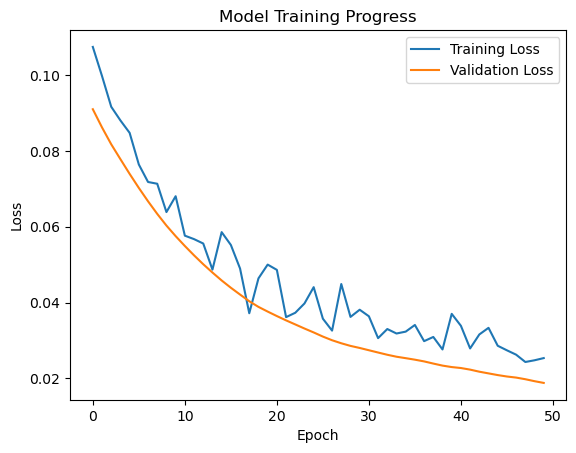

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


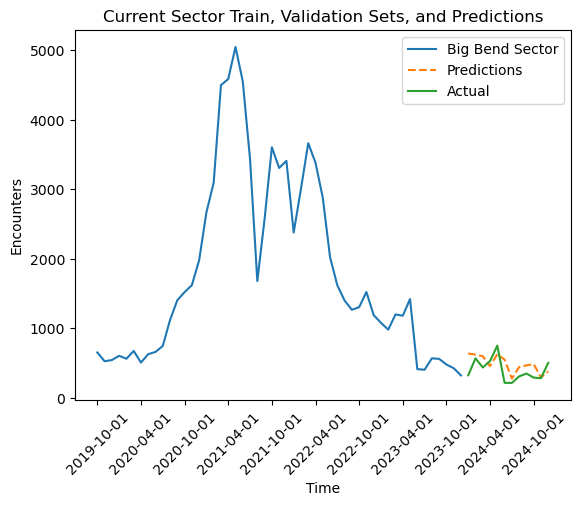

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - loss: 0.1249 - val_loss: 0.1184
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.1140 - val_loss: 0.1162
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1044 - val_loss: 0.1140
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.1129 - val_loss: 0.1119
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.1117 - val_loss: 0.1097
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.1087 - val_loss: 0.1077
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.1111 - val_loss: 0.1056
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.1106 - val_loss: 0.1036
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.1063 - val_loss: 0.1015
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.1018 - val_loss: 0.0994
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0969 - val_loss: 0.0972
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0885 - val_loss: 0.0949


In [134]:
sector_MAPEs = pd.DataFrame(index=test_data.index, columns=test_data.columns)
sector_predictions = pd.DataFrame(index=test_data.index, columns=test_data.columns)


for index in sector_train_scaled.index:
    
    index_integer = sector_train_scaled.index.get_loc(index)

    # Convert the first index of train_data and val_data to numpy arrays
    split_index = 25
    
    train_data_np = np.array(train_data[index_integer][:split_index])
    train_data_y_np = np.array(val_data[index_integer][:split_index])
    
    val_data_np = np.array(train_data[index_integer][:split_index])
    val_data_y_np = np.array(val_data[index_integer][:split_index])

    # Reshape the data to fit the model's input requirements
    # Assuming the model expects input shape (batch_size, input_size)
    train_data_np = train_data_np.reshape(-1, input_size)
    train_data_y_np = train_data_y_np.reshape(-1, 12)
    
    val_data_np = val_data_np.reshape(-1, input_size)
    val_data_y_np = val_data_y_np.reshape(-1, 12)
    
    # Convert numpy arrays to tensors
    train_data_tensor = tf.convert_to_tensor(train_data_np, dtype=tf.float32)
    train_data_y_tensor = tf.convert_to_tensor(train_data_y_np , dtype=tf.float32)
    val_data_tensor = tf.convert_to_tensor(val_data_np, dtype=tf.float32)
    val_data_y_tensor = tf.convert_to_tensor(val_data_y_np, dtype=tf.float32)

    optimizer = Adam(learning_rate=0.0001)

 #   # Define the neural network model
 #   nn_model = Sequential()
 #   nn_model.add(InputLayer(shape=(input_size,)))
 #   nn_model.add(Dense(units=24))
 #   nn_model.add(Dropout(0.3))
 #   nn_model.add(Dense(units=512, activation='relu'))
 #   nn_model.add(Dropout(0.3))
 #   nn_model.add(Dense(units=256, activation='relu'))
 #   nn_model.add(Dropout(0.3))
 #   nn_model.add(Dense(units=128, activation='relu'))
 #   nn_model.add(Dense(units=12, activation='linear'))
#
 #   nn_model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Train the model
    nn_model = Sequential()
    nn_model.add(InputLayer(shape=(input_size,)))
    nn_model.add(Dense(units=24))
    nn_model.add(Dropout(0.3))
    nn_model.add(Dense(units=512, activation='relu'))
    nn_model.add(Dropout(0.3))
    nn_model.add(Dense(units=256, activation='relu'))
    nn_model.add(Dropout(0.3))
    nn_model.add(Dense(units=128, activation='relu'))
    nn_model.add(Dense(units=12, activation='linear'))  # Adjust the output layer to match the target shape

    nn_model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Train the model
    train_progress = nn_model.fit(train_data_tensor, train_data_y_tensor, epochs=50, batch_size=12, validation_data=(val_data_tensor, val_data_y_tensor))

    if index == 'Big Bend Sector':
        # Plot the training loss
        plt.plot(train_progress.history['loss'])
        plt.plot(train_progress.history['val_loss'])
        plt.title('Model Training Progress')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
        plt.show()

    test_input = np.array(sector_train_scaled.iloc[index_integer][-input_size:]).reshape(-1, input_size)

    test_input_tensor = tf.convert_to_tensor(test_input, dtype=tf.float32)

    predictions = nn_model.predict(test_input_tensor)

    current_sector_train = sector_train.loc[index]
    current_sector_actual = test_data.loc[index]
    predictions = scalers[index].inverse_transform(predictions)

    # Plot the current_sector_train data
    if index == 'Big Bend Sector':
        plt.plot(current_sector_train.values, label=index)

        # Plot the predictions data
        plt.plot(range(len(current_sector_train), len(current_sector_train) + len(predictions.flatten())), predictions.flatten(), label='Predictions', linestyle='--')

        # Plot the predictions data
        plt.plot(range(len(current_sector_train), len(current_sector_train) + len(predictions.flatten())), current_sector_actual.values, label='Actual')

        # Set the x-values as dates from the train and test sequences
        dates = list(sector_train.columns) + list(test_data.columns)

        plt.title('Current Sector Train, Validation Sets, and Predictions')
        plt.xlabel('Time')
        plt.ylabel('Encounters')
        plt.xticks(ticks=range(0, len(dates), 6), labels=dates[::6], rotation=45)
        plt.legend()
        plt.show()

    # Calculate MAPE for each time step
    mape_by_time_step = mean_absolute_percentage_error(current_sector_actual.values, predictions.flatten())

    sector_MAPEs.loc[index] = mape_by_time_step
    sector_predictions.loc[index] = predictions



In [ ]:
sector_MAPEs

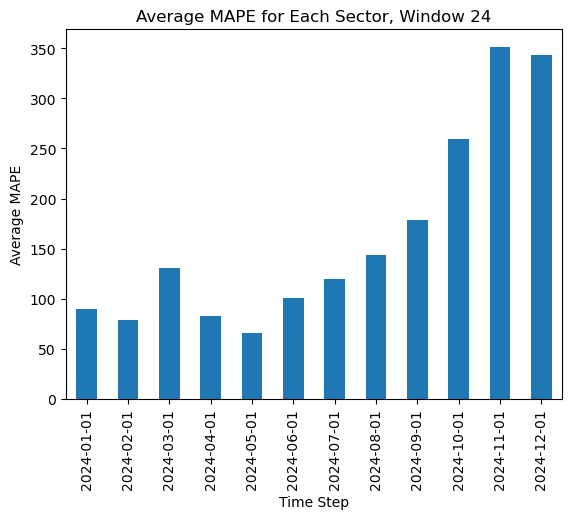

In [137]:
# Calculate the average MAPE for each column
average_MAPE = sector_MAPEs.mean()

# Plot the average MAPE for each column
average_MAPE.plot(kind='bar')
plt.title('Average MAPE for Each Sector, Window 24')
plt.xlabel('Time Step')
plt.ylabel('Average MAPE')
plt.show()

Second iteration, changing hyperparameters Adam learning rate from 0.0001 to 0.0005, nodes have been reduced, perhaps don't need as many nodes to perform well, and dropout rate has been increased to 0.4 to guard against overfitting.

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 326ms/step - loss: 0.3627 - val_loss: 0.2734
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.2971 - val_loss: 0.2478
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.2958 - val_loss: 0.2266
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.2347 - val_loss: 0.2076
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.2292 - val_loss: 0.1900
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.1960 - val_loss: 0.1731
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.1817 - val_loss: 0.1564
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.1672 - val_loss: 0.1397
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1345 - val_loss: 0.1237
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1249 - val_loss: 0.1087
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.1092 - val_loss: 0.0959
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.1074 - val_loss: 0.085

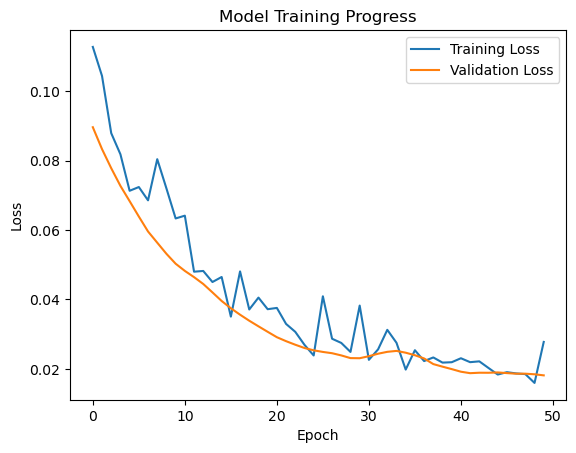

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


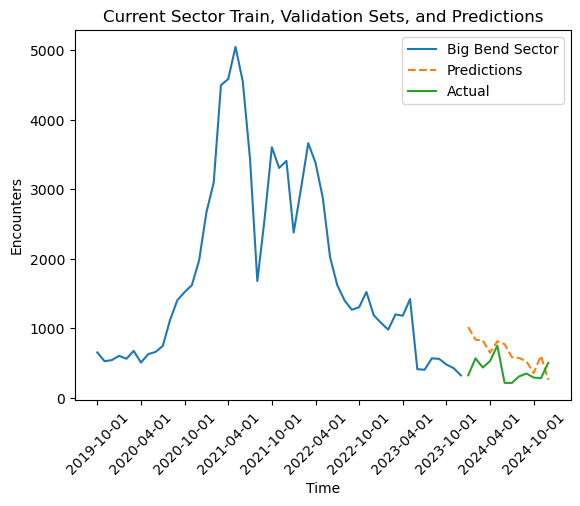

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 239ms/step - loss: 0.1321 - val_loss: 0.1164
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.1154 - val_loss: 0.1129
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.1111 - val_loss: 0.1098
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.1075 - val_loss: 0.1063
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0972 - val_loss: 0.1026
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1029 - val_loss: 0.0985
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.1008 - val_loss: 0.0940
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0881 - val_loss: 0.0892
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0743 - val_loss: 0.0837
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0804 - val_loss: 0.0776
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0760 - val_loss: 0.0714
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0686 - val_loss: 0.0649


In [14]:
sector_MAPEs = pd.DataFrame(index=test_data.index, columns=test_data.columns)
sector_predictions = pd.DataFrame(index=test_data.index, columns=test_data.columns)


for index in sector_train_scaled.index:
    
    index_integer = sector_train_scaled.index.get_loc(index)

    # Convert the first index of train_data and val_data to numpy arrays
    split_index = 25
    
    train_data_np = np.array(train_data[index_integer][:split_index])
    train_data_y_np = np.array(val_data[index_integer][:split_index])
    
    val_data_np = np.array(train_data[index_integer][:split_index])
    val_data_y_np = np.array(val_data[index_integer][:split_index])

    # Reshape the data to fit the model's input requirements
    # Assuming the model expects input shape (batch_size, input_size)
    train_data_np = train_data_np.reshape(-1, input_size)
    train_data_y_np = train_data_y_np.reshape(-1, 12)
    
    val_data_np = val_data_np.reshape(-1, input_size)
    val_data_y_np = val_data_y_np.reshape(-1, 12)
    
    # Convert numpy arrays to tensors
    train_data_tensor = tf.convert_to_tensor(train_data_np, dtype=tf.float32)
    train_data_y_tensor = tf.convert_to_tensor(train_data_y_np , dtype=tf.float32)
    val_data_tensor = tf.convert_to_tensor(val_data_np, dtype=tf.float32)
    val_data_y_tensor = tf.convert_to_tensor(val_data_y_np, dtype=tf.float32)

    optimizer = Adam(learning_rate=0.0005)

 #   # Define the neural network model
 #   nn_model = Sequential()
 #   nn_model.add(InputLayer(shape=(input_size,)))
 #   nn_model.add(Dense(units=24))
 #   nn_model.add(Dropout(0.3))
 #   nn_model.add(Dense(units=512, activation='relu'))
 #   nn_model.add(Dropout(0.3))
 #   nn_model.add(Dense(units=256, activation='relu'))
 #   nn_model.add(Dropout(0.3))
 #   nn_model.add(Dense(units=128, activation='relu'))
 #   nn_model.add(Dense(units=12, activation='linear'))
#
 #   nn_model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Train the model
    nn_model = Sequential()
    nn_model.add(InputLayer(shape=(input_size,)))
    nn_model.add(Dense(units=24))
    nn_model.add(Dropout(0.4))
    nn_model.add(Dense(units=256, activation='relu'))
    nn_model.add(Dropout(0.4))
    nn_model.add(Dense(units=128, activation='relu'))
    nn_model.add(Dropout(0.4))
    nn_model.add(Dense(units=64, activation='relu'))
    nn_model.add(Dense(units=12, activation='linear'))  # Adjust the output layer to match the target shape

    nn_model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Train the model
    train_progress = nn_model.fit(train_data_tensor, train_data_y_tensor, epochs=50, batch_size=12, validation_data=(val_data_tensor, val_data_y_tensor))

    if index == 'Big Bend Sector':
        # Plot the training loss
        plt.plot(train_progress.history['loss'])
        plt.plot(train_progress.history['val_loss'])
        plt.title('Model Training Progress')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
        plt.show()

    test_input = np.array(sector_train_scaled.iloc[index_integer][-input_size:]).reshape(-1, input_size)

    test_input_tensor = tf.convert_to_tensor(test_input, dtype=tf.float32)

    predictions = nn_model.predict(test_input_tensor)

    current_sector_train = sector_train.loc[index]
    current_sector_actual = test_data.loc[index]
    predictions = scalers[index].inverse_transform(predictions)

    # Plot the current_sector_train data
    if index == 'Big Bend Sector':
        plt.plot(current_sector_train.values, label=index)

        # Plot the predictions data
        plt.plot(range(len(current_sector_train), len(current_sector_train) + len(predictions.flatten())), predictions.flatten(), label='Predictions', linestyle='--')

        # Plot the predictions data
        plt.plot(range(len(current_sector_train), len(current_sector_train) + len(predictions.flatten())), current_sector_actual.values, label='Actual')

        # Set the x-values as dates from the train and test sequences
        dates = list(sector_train.columns) + list(test_data.columns)

        plt.title('Current Sector Train, Validation Sets, and Predictions')
        plt.xlabel('Time')
        plt.ylabel('Encounters')
        plt.xticks(ticks=range(0, len(dates), 6), labels=dates[::6], rotation=45)
        plt.legend()
        plt.show()

    # Calculate MAPE for each time step
    mape_by_time_step = mean_absolute_percentage_error(current_sector_actual.values, predictions.flatten())

    sector_MAPEs.loc[index] = mape_by_time_step
    sector_predictions.loc[index] = predictions



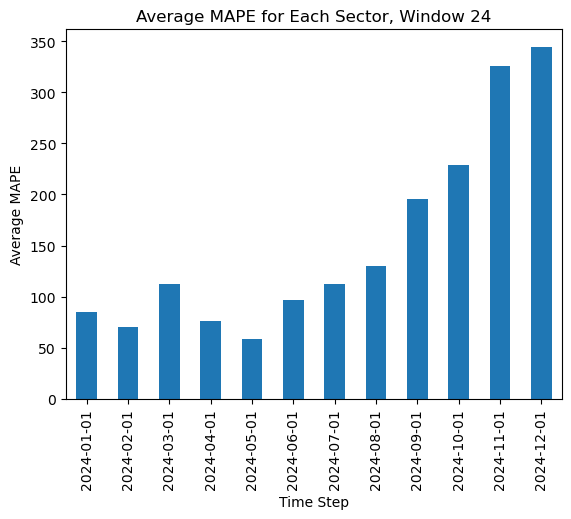

In [15]:
# Calculate the average MAPE for each column
average_MAPE = sector_MAPEs.mean()

# Plot the average MAPE for each column
average_MAPE.plot(kind='bar')
plt.title('Average MAPE for Each Sector, Window 24')
plt.xlabel('Time Step')
plt.ylabel('Average MAPE')
plt.show()

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 287ms/step - loss: 0.2805 - val_loss: 0.1539
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1394 - val_loss: 0.0572
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0827 - val_loss: 0.0632
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1036 - val_loss: 0.0364
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0489 - val_loss: 0.0449
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0526 - val_loss: 0.0548
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0497 - val_loss: 0.0511
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0565 - val_loss: 0.0430
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0429 - val_loss: 0.0377
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0415 - val_loss: 0.0359
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0384 - val_loss: 0.0351
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0475 - val_loss: 0.0363


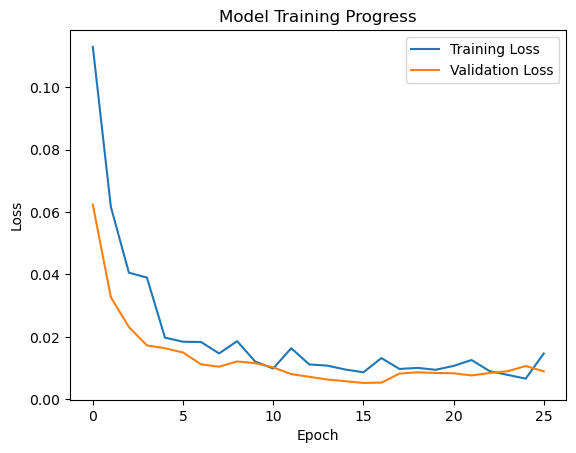

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


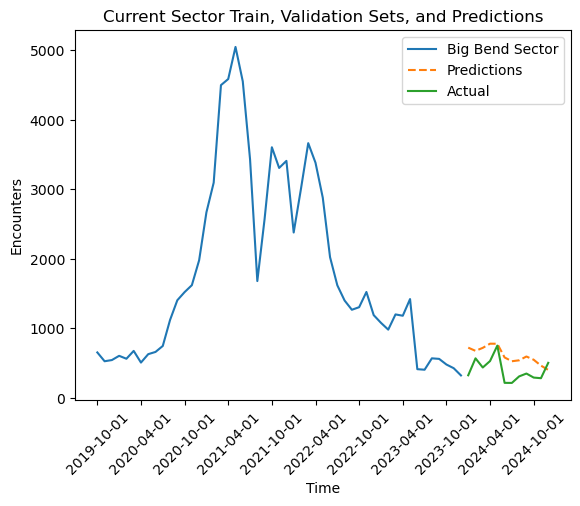

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - loss: 0.1091 - val_loss: 0.0903
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0916 - val_loss: 0.0464
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0423 - val_loss: 0.0204
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0295 - val_loss: 0.0199
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0274 - val_loss: 0.0098
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0142 - val_loss: 0.0166
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0169 - val_loss: 0.0222
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.0221 - val_loss: 0.0216
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0205 - val_loss: 0.0157
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0125 - val_loss: 0.0097
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0111 - val_loss: 0.0082
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0119 - val_loss: 0.0079
Ep

In [17]:
sector_MAPEs = pd.DataFrame(index=test_data.index, columns=test_data.columns)
sector_predictions = pd.DataFrame(index=test_data.index, columns=test_data.columns)

from tensorflow.keras.callbacks import EarlyStopping

for index in sector_train_scaled.index:
    
    index_integer = sector_train_scaled.index.get_loc(index)

    # Convert the first index of train_data and val_data to numpy arrays
    split_index = 25
    
    train_data_np = np.array(train_data[index_integer][:split_index])
    train_data_y_np = np.array(val_data[index_integer][:split_index])
    
    val_data_np = np.array(train_data[index_integer][:split_index])
    val_data_y_np = np.array(val_data[index_integer][:split_index])

    # Reshape the data to fit the model's input requirements
    # Assuming the model expects input shape (batch_size, input_size)
    train_data_np = train_data_np.reshape(-1, input_size)
    train_data_y_np = train_data_y_np.reshape(-1, 12)
    
    val_data_np = val_data_np.reshape(-1, input_size)
    val_data_y_np = val_data_y_np.reshape(-1, 12)
    
    # Convert numpy arrays to tensors
    train_data_tensor = tf.convert_to_tensor(train_data_np, dtype=tf.float32)
    train_data_y_tensor = tf.convert_to_tensor(train_data_y_np , dtype=tf.float32)
    val_data_tensor = tf.convert_to_tensor(val_data_np, dtype=tf.float32)
    val_data_y_tensor = tf.convert_to_tensor(val_data_y_np, dtype=tf.float32)

    optimizer = Adam(learning_rate=0.001)

    # Train the model
    nn_model = Sequential()
    nn_model.add(InputLayer(shape=(input_size,)))
    nn_model.add(Dense(units=24))
    nn_model.add(Dropout(0.2))
    nn_model.add(Dense(units=1028, activation='relu'))
    nn_model.add(Dropout(0.2))
    nn_model.add(Dense(units=514, activation='relu'))
    nn_model.add(Dropout(0.2))
    nn_model.add(Dense(units=256, activation='relu'))
    nn_model.add(Dropout(0.2))
    nn_model.add(Dense(units=128, activation='relu'))
    nn_model.add(Dense(units=12, activation='linear'))  # Adjust the output layer to match the target shape

    nn_model.compile(optimizer=optimizer, loss='mean_squared_error')
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


    # Train the model
    train_progress = nn_model.fit(train_data_tensor, train_data_y_tensor, epochs=50, batch_size=12, validation_data=(val_data_tensor, val_data_y_tensor), callbacks=[early_stopping])

    if index == 'Big Bend Sector':
        # Plot the training loss
        plt.plot(train_progress.history['loss'])
        plt.plot(train_progress.history['val_loss'])
        plt.title('Model Training Progress')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
        plt.show()

    test_input = np.array(sector_train_scaled.iloc[index_integer][-input_size:]).reshape(-1, input_size)

    test_input_tensor = tf.convert_to_tensor(test_input, dtype=tf.float32)

    predictions = nn_model.predict(test_input_tensor)

    current_sector_train = sector_train.loc[index]
    current_sector_actual = test_data.loc[index]
    predictions = scalers[index].inverse_transform(predictions)

    # Plot the current_sector_train data
    if index == 'Big Bend Sector':
        plt.plot(current_sector_train.values, label=index)

        # Plot the predictions data
        plt.plot(range(len(current_sector_train), len(current_sector_train) + len(predictions.flatten())), predictions.flatten(), label='Predictions', linestyle='--')

        # Plot the predictions data
        plt.plot(range(len(current_sector_train), len(current_sector_train) + len(predictions.flatten())), current_sector_actual.values, label='Actual')

        # Set the x-values as dates from the train and test sequences
        dates = list(sector_train.columns) + list(test_data.columns)

        plt.title('Current Sector Train, Validation Sets, and Predictions')
        plt.xlabel('Time')
        plt.ylabel('Encounters')
        plt.xticks(ticks=range(0, len(dates), 6), labels=dates[::6], rotation=45)
        plt.legend()
        plt.show()

    # Calculate MAPE for each time step
    mape_by_time_step = mean_absolute_percentage_error(current_sector_actual.values, predictions.flatten())

    sector_MAPEs.loc[index] = mape_by_time_step
    sector_predictions.loc[index] = predictions



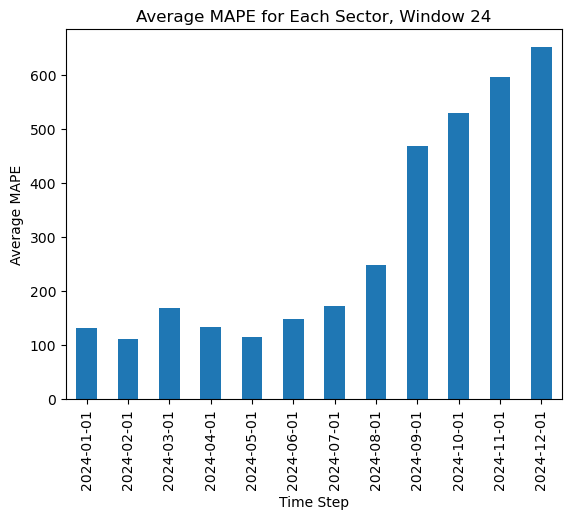

In [18]:
# Calculate the average MAPE for each column
average_MAPE = sector_MAPEs.mean()

# Plot the average MAPE for each column
average_MAPE.plot(kind='bar')
plt.title('Average MAPE for Each Sector, Window 24')
plt.xlabel('Time Step')
plt.ylabel('Average MAPE')
plt.show()